### Translation for kor → eng

In [38]:
import sys
sys.path.insert(0, '../attention-is-all-you-need/')
sys.path.insert(0, '../modeling')

In [39]:
import sentencepiece as spm
import random
import pandas as pd
import torch
import os
import numpy as np
from setting import *
from dataset import load_dataset, KRENField, KRENDataset
from utils import get_sentencepiece

In [40]:
SRC = KRENField(
    #tokenize=inp_lang.EncodeAsPieces,
    pad_token='<pad>')
TRG = KRENField(
    #tokenize=out_lang.EncodeAsPieces,
    init_token='<s>',
    eos_token='</s>',
    pad_token='<pad>')

In [41]:
def load_dataset_aihub(path='../dataset/aihub'):
    sent_pairs = []
    for f in os.listdir(path):
        one_df = pd.read_excel(os.path.join(path, f))
        one_df = one_df.rename(columns={
            '영어':'eng',
            '한국어':'kor',
            '원문':'kor',
            '영어 검수':'label',
            '영어검수':'label',
            '번역문':'label',
            'Review':'label',
            'REVIEW':'label',
        })
        sent_pairs.extend(one_df[['kor','label']].values.tolist())
    return sent_pairs

In [42]:
#sent_pairs = load_dataset_aihub('../attention-is-all-you-need/data')
sent_pairs = load_dataset_aihub()

In [43]:
random.seed(100)
random.shuffle(sent_pairs)

In [44]:
n_train = int(len(sent_pairs) * 0.8)
sent_pairs = sent_pairs[:n_train]
len(sent_pairs)

1281934

In [45]:
for s in sent_pairs[:5]:
    print(s[0])

이러한 인공도시가 시(市)로 출발[1986년 1월 1일]한 지 20여 년 만에 안산시는 몰라보게 변모하였다.
결론을 먼저 얘기해서 너의 드라마 보는 재미를 망치고 싶지는 않아.
그런 박성현의 추격에 기가 죽은 살라스는 마지막 18번홀(파4)에서 2m도 안되는 거리의 버디퍼트를 놓치면서 연장전을 허용했고 결국 우승컵을 헌납했다.
바른미래당·민주평화당이 송영무 국방부 장관의 여성 비하 발언을 지적했다.
손 의원 문제에 대해 검찰이 수사에 착수했습니다.


In [46]:
for s in sent_pairs[:5]:
    print(s[1])

More than twenty years after starting off as such an artificial city(January 1, 1986), Ansan City has been dramatically transformed.
I don't want to spoil your fun of watching the show by telling you the conclusion.
In the pursuit of Park Sung-hyun, Salas missed a birdie putt less than 2 meters away from the last 18 holes (par 4) and allowed overtime and eventually dedicated the championship cup.
The Bareunmirae Party and the Democratic Peace Party pointed out about National Defense Minister Song Young-moo's disparaging remarks against women.
Prosecutors have launched an investigation on Sohn's issue.


In [47]:
with open('./spm_src.txt', 'w', encoding='utf-8') as f:
    for sent in sent_pairs:
        f.write('{}\n'.format(sent[0]))

In [48]:
with open('./spm_trg.txt', 'w', encoding='utf-8') as f:
    for sent in sent_pairs:
        f.write('{}\n'.format(sent[1]))

In [49]:
! wc -l ./spm_*.txt

  1281934 ./spm_src.txt
  1281934 ./spm_trg.txt
  2563868 total


In [50]:
! head -n 3 ./spm_src.txt

이러한 인공도시가 시(市)로 출발[1986년 1월 1일]한 지 20여 년 만에 안산시는 몰라보게 변모하였다.
결론을 먼저 얘기해서 너의 드라마 보는 재미를 망치고 싶지는 않아.
그런 박성현의 추격에 기가 죽은 살라스는 마지막 18번홀(파4)에서 2m도 안되는 거리의 버디퍼트를 놓치면서 연장전을 허용했고 결국 우승컵을 헌납했다.


In [51]:
! head -n 3 ./spm_trg.txt

More than twenty years after starting off as such an artificial city(January 1, 1986), Ansan City has been dramatically transformed.
I don't want to spoil your fun of watching the show by telling you the conclusion.
In the pursuit of Park Sung-hyun, Salas missed a birdie putt less than 2 meters away from the last 18 holes (par 4) and allowed overtime and eventually dedicated the championship cup.


In [52]:
sent_pairs[0]

['이러한 인공도시가 시(市)로 출발[1986년 1월 1일]한 지 20여 년 만에 안산시는 몰라보게 변모하였다.',
 'More than twenty years after starting off as such an artificial city(January 1, 1986), Ansan City has been dramatically transformed.']

In [53]:
src_vocab_size = 50000  # 50000
trg_vocab_size = 32000  # 32000
src_prefix = 'spm-src-{}'.format(src_vocab_size)
trg_prefix = 'spm-trg-{}'.format(trg_vocab_size)
src_prefix, trg_prefix

('spm-src-50000', 'spm-trg-32000')

In [54]:
src_cmd = templates.format(
    src_input_file,
    pad_id,
    bos_id,
    eos_id,
    unk_id,
    src_prefix,
    src_vocab_size,
    character_coverage,
    model_type)
src_cmd

'--input=./spm_src.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=spm-src-50000 --vocab_size=50000 --character_coverage=1.0 --model_type=unigram'

In [55]:
trg_cmd = templates.format(
    trg_input_file,
    pad_id,
    bos_id,
    eos_id,
    unk_id,
    trg_prefix,
    trg_vocab_size,
    character_coverage,
    model_type)
trg_cmd

'--input=./spm_trg.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=spm-trg-32000 --vocab_size=32000 --character_coverage=1.0 --model_type=unigram'

In [56]:
spm.SentencePieceTrainer.Train(src_cmd)
spm.SentencePieceTrainer.Train(trg_cmd)

True

In [57]:
! ls -alh *.model

-rw-r--r-- 1 jkfirst deep-learners 1.2M  4월  8 15:47 spm-src-50000.model
-rw-r--r-- 1 jkfirst deep-learners 791K  4월  8 15:49 spm-trg-32000.model


In [58]:
src_spm = spm.SentencePieceProcessor()
trg_spm = spm.SentencePieceProcessor()
trg_spm.extra_options='bos:eos'
src_spm.Load('{}.model'.format(src_prefix)) 
trg_spm.Load('{}.model'.format(trg_prefix))

True

In [59]:
with open('{}.vocab'.format(src_prefix), encoding='utf-8') as f:
    src_vocab = [doc.strip() for doc in f]
src_vocab[:10]

['<pad>\t0',
 '<s>\t0',
 '</s>\t0',
 '<unk>\t0',
 '.\t-3.13506',
 '을\t-3.97448',
 '의\t-4.15374',
 ',\t-4.19906',
 '를\t-4.36734',
 '가\t-4.45907']

In [60]:
with open('{}.vocab'.format(trg_prefix), encoding='utf-8') as f:
    trg_vocab = [doc.strip() for doc in f]
trg_vocab[:10]

['<pad>\t0',
 '<s>\t0',
 '</s>\t0',
 '<unk>\t0',
 '▁the\t-2.83341',
 ',\t-3.18428',
 '.\t-3.36774',
 '▁of\t-3.55744',
 '▁and\t-3.77447',
 '▁to\t-3.80803']

In [61]:
idx = np.random.randint(0, len(sent_pairs))
idx
src_spm.EncodeAsPieces(sent_pairs[idx][0])

['▁경기',
 '패션',
 '창작',
 '스튜디오',
 '▁도내',
 '▁섬유',
 '소재',
 '와',
 '▁협업',
 '을',
 '▁통해',
 '▁국내외',
 '▁시장',
 '진출',
 '▁확대',
 '▁및',
 '▁글로벌',
 '▁패션',
 '브랜드',
 '▁육성',
 '을',
 '▁목표로',
 '▁지난',
 '▁2016',
 '년',
 '▁경기도와',
 '▁양주시',
 '가',
 '▁설치한',
 '▁디자인',
 '▁창작',
 '공간',
 '이다',
 '.']

In [62]:
idx = np.random.randint(0, len(sent_pairs))
trg_spm.EncodeAsPieces(sent_pairs[idx][1])

['▁It',
 '▁is',
 '▁very',
 '▁important',
 '▁how',
 '▁to',
 '▁spend',
 '▁the',
 '▁first',
 '▁grade',
 ',',
 '▁which',
 '▁is',
 '▁of',
 '▁the',
 '▁free',
 '▁school',
 '▁year',
 '.']

In [63]:
idx = np.random.randint(0, len(sent_pairs))
src_sent = trg_spm.EncodeAsPieces(sent_pairs[idx][0])
trg_sent = trg_spm.EncodeAsPieces(sent_pairs[idx][1])
src_sent, trg_sent

(['▁',
  '이',
  '▁',
  '같은',
  '▁',
  '비즈니스',
  '▁',
  '모델이',
  '▁',
  '가능하게',
  '▁',
  '된',
  '▁',
  '것은',
  '▁',
  '애플',
  '▁',
  '창업자인',
  '▁',
  '스티브',
  '▁',
  '잡스',
  '▁',
  '전',
  '▁',
  '최고경영자',
  '(',
  'CEO',
  ')',
  '를',
  '▁',
  '빠뜨릴',
  '▁',
  '수',
  '▁',
  '없다',
  '.'],
 ['▁One',
  '▁of',
  '▁the',
  '▁people',
  '▁who',
  '▁made',
  '▁this',
  '▁business',
  '▁model',
  '▁possible',
  '▁is',
  '▁Apple',
  '▁founder',
  '▁Steve',
  '▁Jobs',
  '.'])

In [64]:
len(sent_pairs)

1281934

In [65]:
train, valid, test = KRENDataset.splits(sent_pairs, (SRC, TRG), src_spm, trg_spm, encoding_type='pieces')

Encoding as pieces: 100%|██████████| 26004/26004 [00:01<00:00, 17107.26it/s]


In [66]:
SRC.build_vocab(train.src, '{}.vocab'.format(src_prefix))

In [67]:
TRG.build_vocab(train.trg, '{}.vocab'.format(trg_prefix))

In [68]:
src_spm

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7f862924d510> >

In [69]:
SRC.vocab.stoi

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '.': 4,
 '을': 5,
 '의': 6,
 ',': 7,
 '를': 8,
 '가': 9,
 '는': 10,
 '이': 11,
 '에': 12,
 '은': 13,
 '▁수': 14,
 '▁': 15,
 '▁있다': 16,
 '과': 17,
 '도': 18,
 '고': 19,
 '로': 20,
 '▁‘': 21,
 '일': 22,
 ')': 23,
 '’': 24,
 '와': 25,
 '▁“': 26,
 '에서': 27,
 '(': 28,
 '·': 29,
 '으로': 30,
 '▁이': 31,
 '”': 32,
 '▁있는': 33,
 '▁등': 34,
 '한': 35,
 '인': 36,
 '?': 37,
 '다': 38,
 '년': 39,
 '▁한다': 40,
 '▁1': 41,
 '▁한': 42,
 '▁제': 43,
 '▁그': 44,
 '▁및': 45,
 '▁것으로': 46,
 '▁2': 47,
 '월': 48,
 '만': 49,
 '할': 50,
 '▁3': 51,
 '▁대한': 52,
 '지': 53,
 '하는': 54,
 '▁전': 55,
 '하고': 56,
 '▁위해': 57,
 '해': 58,
 '▁것': 59,
 '▁경우': 60,
 '▁더': 61,
 '▁5': 62,
 '▁할': 63,
 '▁4': 64,
 '▁따라': 65,
 '▁중': 66,
 '▁지난': 67,
 '▁통해': 68,
 '기': 69,
 '▁나는': 70,
 '나': 71,
 '▁10': 72,
 '▁함께': 73,
 '시': 74,
 '들이': 75,
 '▁밝혔다': 76,
 '하게': 77,
 '▁한국': 78,
 '개': 79,
 '며': 80,
 '대': 81,
 '▁하는': 82,
 '▁이번': 83,
 '▁때': 84,
 '까지': 85,
 '▁내': 86,
 '▁있습니다': 87,
 '▁것이': 88,
 '▁많은': 89,
 '▁위한': 90,
 '에는': 91,
 '

In [70]:
TRG.vocab.stoi

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '▁the': 4,
 ',': 5,
 '.': 6,
 '▁of': 7,
 '▁and': 8,
 '▁to': 9,
 '▁a': 10,
 '▁in': 11,
 '-': 12,
 '▁is': 13,
 's': 14,
 '▁that': 15,
 "'": 16,
 '▁for': 17,
 '▁on': 18,
 '▁The': 19,
 '▁I': 20,
 '▁as': 21,
 '▁it': 22,
 '▁be': 23,
 '▁with': 24,
 '▁was': 25,
 '▁by': 26,
 '▁are': 27,
 '▁will': 28,
 '▁"': 29,
 '▁at': 30,
 '▁from': 31,
 '▁you': 32,
 '▁have': 33,
 '▁has': 34,
 '▁which': 35,
 '▁who': 36,
 '▁not': 37,
 '▁an': 38,
 '▁this': 39,
 '▁Korea': 40,
 '▁but': 41,
 '▁can': 42,
 '▁or': 43,
 '▁In': 44,
 'th': 45,
 '▁(': 46,
 '▁said': 47,
 '▁It': 48,
 '▁shall': 49,
 '?': 50,
 '▁year': 51,
 '▁been': 52,
 '▁time': 53,
 '▁were': 54,
 't': 55,
 '▁he': 56,
 '"': 57,
 '▁there': 58,
 '▁Korean': 59,
 '▁Kim': 60,
 '▁his': 61,
 '▁such': 62,
 '."': 63,
 '▁also': 64,
 '▁so': 65,
 '▁people': 66,
 '▁after': 67,
 '▁when': 68,
 '▁more': 69,
 '▁they': 70,
 '▁their': 71,
 'ing': 72,
 '▁if': 73,
 ')': 74,
 '▁than': 75,
 '▁first': 76,
 '▁about': 77,
 '▁head': 78,

In [71]:
TRG.vocab.stoi['<s>']

1

In [72]:
torch.save(SRC.vocab, '../attention-is-all-you-need/spm/{}.spm'.format(src_prefix))
torch.save(TRG.vocab, '../attention-is-all-you-need/spm/{}.spm'.format(trg_prefix))
src_prefix, trg_prefix

('spm-src-50000', 'spm-trg-32000')

In [73]:
for t in train:
    print(t.trg)
    break

['▁Prosecutors', '▁have', '▁launched', '▁an', '▁investigation', '▁on', '▁Sohn', "'", 's', '▁issue', '.']


In [38]:
acc = [0.8385,
0.8641,
0.8941,
0.9112,
0.9175,
0.9200,
0.9238,
0.9242,
0.9252,
0.9339,
0.9391,
0.9413,
0.9473,
0.9487,
0.9490,
0.9517,
0.9552,
0.9577,
0.9676,
0.9678,
0.9704,
0.9717,
0.9734]

In [40]:
import matplotlib.pyplot as plt

(array([1., 1., 0., 0., 1., 2., 4., 3., 6., 5.]),
 array([0.8385 , 0.85199, 0.86548, 0.87897, 0.89246, 0.90595, 0.91944,
        0.93293, 0.94642, 0.95991, 0.9734 ]),
 <a list of 10 Patch objects>)

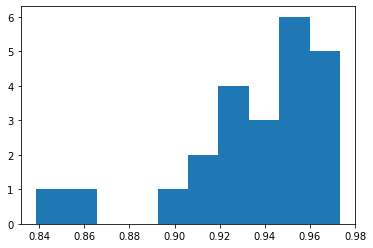

In [43]:
plt.hist(acc)